<div align='right'>
    Mathematics in Machine Learning (01TXGSM)<br>
    Politecnico di Torino - Academic Year 2021/22
</div>

<div align='center'> 
    <h1 style=font-size:2.5em>Predicting credit card defaults with machine learning algorithms</h1><br>
</div>

<div>
    <p style='text-align:left;'>
        Prof. Francesco Vaccarino<br>
        Prof. Mauro Gasparini
        <span style='float:right;'>
            Student: <a href='mailto:s287576@studenti.polito.it'>Matteo Merlo - 287576</a>
        </span>
    </p>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE, KMeansSMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, auc, recall_score,  confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')
random_state = 42

In [3]:
df = pd.read_csv('dataset/default_of_credit_card_clients.csv')
df = df.rename(columns={"PAY_0": "PAY_1"}, errors="raise")
df = df.rename(columns={'default payment next month': 'DEFAULT'}, errors="raise")
df = df.drop("ID", axis=1, inplace=False)

# 1 General Overview

In [4]:
df.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0


In [5]:
df.info()

# > all numerical attributes
# > no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [57]:
df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500
std,129747.661567,0.489129,0.790349,0.521970,9.217904
min,10000.000000,1.000000,0.000000,0.000000,21.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000


In [58]:
#  Gender (1 = male; 2 = female).
#  Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
#  Marital status (1 = married; 2 = single; 3 = others). 
#  default payment next month 	(1 = yes; 0 = no)

no_categorical = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

desc = df[no_categorical].describe().round(2)

desc

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00
mean,167484.32,35.49,51223.33,49179.08,47013.15,43262.95,40311.40,38871.76,5663.58,5921.16,5225.68,4826.08,4799.39,5215.50
std,129747.66,9.22,73635.86,71173.77,69349.39,64332.86,60797.16,59554.11,16563.28,23040.87,17606.96,15666.16,15278.31,17777.47
min,10000.00,21.00,-165580.00,-69777.00,-157264.00,-170000.00,-81334.00,-339603.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,50000.00,28.00,3558.75,2984.75,2666.25,2326.75,1763.00,1256.00,1000.00,833.00,390.00,296.00,252.50,117.75
50%,140000.00,34.00,22381.50,21200.00,20088.50,19052.00,18104.50,17071.00,2100.00,2009.00,1800.00,1500.00,1500.00,1500.00
75%,240000.00,41.00,67091.00,64006.25,60164.75,54506.00,50190.50,49198.25,5006.00,5000.00,4505.00,4013.25,4031.50,4000.00
max,1000000.00,79.00,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00,873552.00,1684259.00,896040.00,621000.00,426529.00,528666.00


# 2. Exploration Data Analisys

In [59]:
from collections import Counter

counterDEF = Counter(df['DEFAULT'])
print(counterDEF)

print(f"Percentage DEFAULT of 0 : {counterDEF[0]/len(df)}")
print(f"Percentage DEFAULT of 1 : {counterDEF[1]/len(df)}")


counterEDU = Counter(df['EDUCATION'])
print(counterEDU)

print(f"Percentage EDUCATION of 2 : {counterEDU[2]/len(df)}")
print(f"Percentage EDUCATION of 1 : {counterEDU[1]/len(df)}")

Counter({0: 23364, 1: 6636})
Percentage DEFAULT of 0 : 0.7788
Percentage DEFAULT of 1 : 0.2212
Counter({2: 14030, 1: 10585, 3: 4917, 5: 280, 4: 123, 6: 51, 0: 14})
Percentage EDUCATION of 2 : 0.4676666666666667
Percentage EDUCATION of 1 : 0.35283333333333333


### 2.1 Data cleaning

In [60]:
print(f"Value in SEX attribute column: {set(df['SEX'])}")
print(f"Value in EDUCATION attribute column: {set(df['EDUCATION'])}")
print(f"Value in MARRIAGE attribute column: {set(df['MARRIAGE'])}")
print(f"Value in RESPONSE (YES or NO) column: {set(df['DEFAULT'])}")
print(f"Value in PAY_1 column: {set(df['PAY_1'])}")      
print(f"Value in PAY_2 column: {set(df['PAY_2'])}")      
print(f"Value in PAY_3 column: {set(df['PAY_3'])}")      
print(f"Value in PAY_4 column: {set(df['PAY_4'])}")      
print(f"Value in PAY_5 column: {set(df['PAY_5'])}")      
print(f"Value in PAY_6 column: {set(df['PAY_6'])}")  

Value in SEX attribute column: {1, 2}
Value in EDUCATION attribute column: {0, 1, 2, 3, 4, 5, 6}
Value in MARRIAGE attribute column: {0, 1, 2, 3}
Value in RESPONSE (YES or NO) column: {0, 1}
Value in PAY_1 column: {0, 1, 2, 3, 4, 5, 6, 7, 8, -2, -1}
Value in PAY_2 column: {0, 1, 2, 3, 4, 5, 6, 7, 8, -2, -1}
Value in PAY_3 column: {0, 1, 2, 3, 4, 5, 6, 7, 8, -2, -1}
Value in PAY_4 column: {0, 1, 2, 3, 4, 5, 6, 7, 8, -2, -1}
Value in PAY_5 column: {0, 2, 3, 4, 5, 6, 7, 8, -1, -2}
Value in PAY_6 column: {0, 2, 3, 4, 5, 6, 7, 8, -1, -2}


In [61]:
df['EDUCATION'].value_counts().sort_index()

0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64

In [62]:
df['MARRIAGE'].value_counts().sort_index()

0       54
1    13659
2    15964
3      323
Name: MARRIAGE, dtype: int64

In [63]:
print(f"Dataset size before:\t{df.shape[0]}")
df = df.drop(df[df['MARRIAGE']==0].index)
df = df.drop(df[df['EDUCATION']==0].index)
df = df.drop(df[df['EDUCATION']==5].index)
df = df.drop(df[df['EDUCATION']==6].index)
print(f"Dataset size after:\t{df.shape[0]}")

Dataset size before:	30000
Dataset size after:	29601


In [64]:
pay_features = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for p in pay_features:
    df.loc[df[p]<0, p] = -1
    df.loc[df[p]>=0, p] = df.loc[df[p]>=0, p] + 1
    df[p] = df[p].astype('int64')

### 2.2 Imbalance dataset

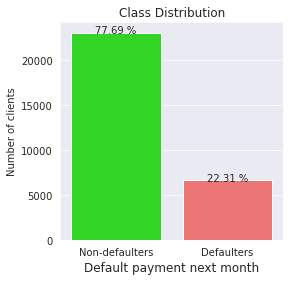

In [106]:
plt.figure(figsize = (4,4))
graph_target = sns.countplot(x="DEFAULT", data=df, palette=['#19F108','#FF6363'])

i=0
for p in graph_target.patches:
    height = p.get_height()
    
    percentage = round(100 * df["DEFAULT"].value_counts()[i] / len(df),2)
    
    str_plot = f'{percentage} %'
    
    graph_target.text(p.get_x()+p.get_width()/2., height - 100, str_plot, ha="center")
    i += 1

plt.xticks([0,1],['Non-defaulters', 'Defaulters'])
plt.xlabel('Default payment next month', fontsize=12)
plt.ylabel('Number of clients')
plt.savefig('images/imbalanced_plot.svg')
plt.title('Class Distribution')
plt.show()

### 2.3 Continuos features

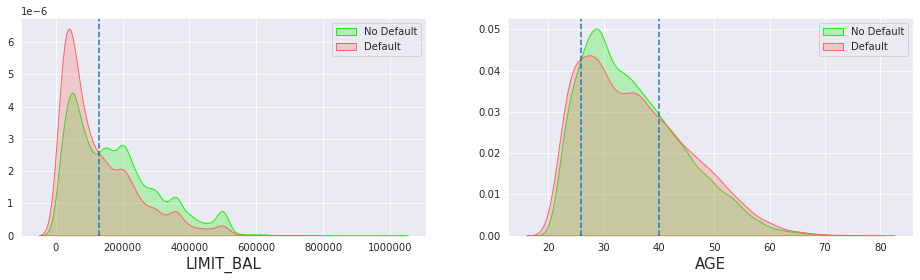

In [105]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.kdeplot(df.loc[(df['DEFAULT'] == 0), 'LIMIT_BAL'], label = 'No Default', shade = True, color="#19F108")
sns.kdeplot(df.loc[(df['DEFAULT'] == 1), 'LIMIT_BAL'], label = 'Default', shade = True, color="#FF6363")
plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation on x
plt.xlabel('LIMIT_BAL', fontsize=15)
plt.ylabel('')
plt.axvline(0.13*1e6, 0, ls='--')
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(df.loc[(df['DEFAULT'] == 0), 'AGE'], label = 'No Default', shade = True, color="#19F108")
sns.kdeplot(df.loc[(df['DEFAULT'] == 1), 'AGE'], label = 'Default', shade = True, color="#FF6363")
plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation on x
plt.xlabel('AGE', fontsize=15)
plt.ylabel('')
plt.axvline(26, 0, ls='--')
plt.axvline(40, 0, ls='--')
plt.legend()

plt.savefig('images/continuosDistribution.svg')
plt.show();


### 2.4 Categorical features

In [97]:
def plot_categorical_distribution(df,feature,order,ticks,rotation,ax):
    
    graph = sns.countplot(x=feature, data=df, order=order, ax=ax, 
                          hue="DEFAULT", palette=['#19F108', '#FF6363'])    
    
    for p in ax.patches:
        if not math.isnan(p.get_height()):
            height = int(p.get_height())
        else:
            height = 0
            
        ax.annotate(height, (p.get_x()-0.025, p.get_height()+500))
        
    graph.set(xticklabels=ticks)
    ax.tick_params(axis='x', rotation=rotation)
    ax.set_xlabel(feature,fontsize=15)
    ax.legend(['No Default','Default'])

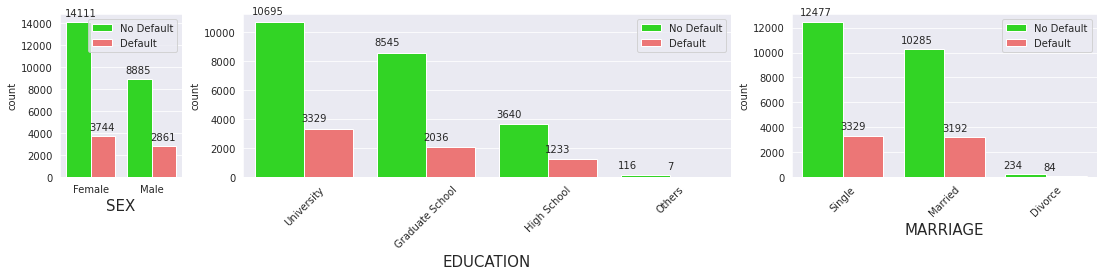

In [101]:
sns.set_color_codes('pastel')
order_marriage = df["MARRIAGE"].value_counts().index
label_marriage = ['Single','Married','Divorce']

order_education = df["EDUCATION"].value_counts().index
label_education = ["University","Graduate School","High School","Others"]

order_sex = df["SEX"].value_counts().index
label_sex = ["Female","Male"]

fig = plt.figure(constrained_layout=False,figsize=(18,3))
gs1 = fig.add_gridspec(nrows=1, ncols=6, left=0.1, right=0.90, wspace=0.5)
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1:4])
ax3 = fig.add_subplot(gs1[0, 4:6])

plot_categorical_distribution(df,"SEX",order_sex,label_sex,0,ax1)
plot_categorical_distribution(df,"EDUCATION",order_education,label_education,45,ax2)
plot_categorical_distribution(df,"MARRIAGE",order_marriage,label_marriage,45,ax3)

plt.savefig('images/categoricalDistribution.svg')

plt.show();

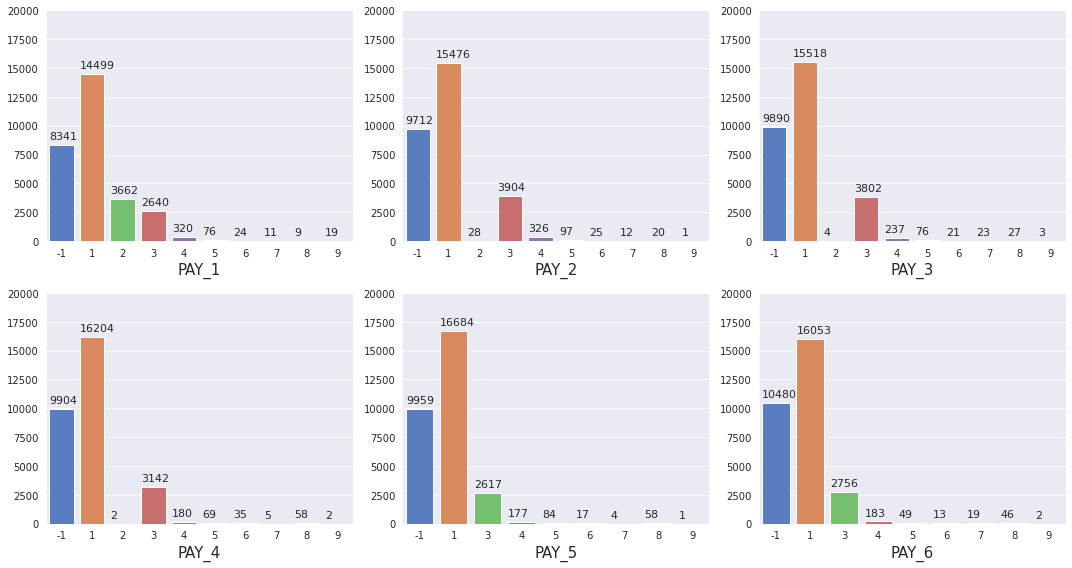

In [74]:
PAY_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
plt.figure(figsize=(15,8))

for i, col in enumerate(PAY_cols):    
    plt.subplot(2,3,i + 1)
    ax = sns.countplot(df.loc[:,col], palette = 'muted')
    plt.ylim(0,20000)
    plt.xlabel(col,fontsize=15)
    plt.ylabel('')
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x(), p.get_height()+500), fontsize = 11)

plt.savefig('images/categoricalPAY.svg')
plt.show()

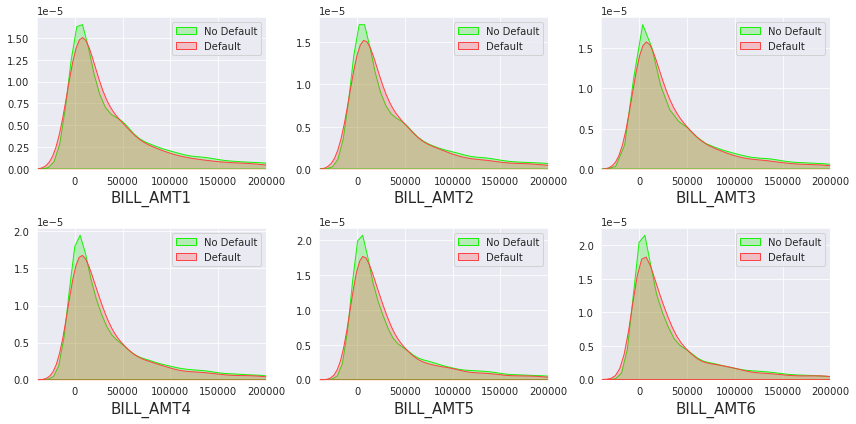

In [75]:
BILL_AMT_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
plt.figure(figsize=(12,6))

for i,col in enumerate(BILL_AMT_cols):    
    plt.subplot(2,3,i + 1)    
    sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default',color="#19F108", shade=True)
    sns.kdeplot(df.loc[(df['DEFAULT'] == 1), col], label = 'Default', color="#FF6363", shade=True)
    plt.xlim(-40000,200000)
    plt.ylabel('')
    plt.xlabel(col,fontsize=15)
    plt.legend()
    plt.tight_layout()

plt.savefig('images/continuousBILLAMT.svg')
plt.show()

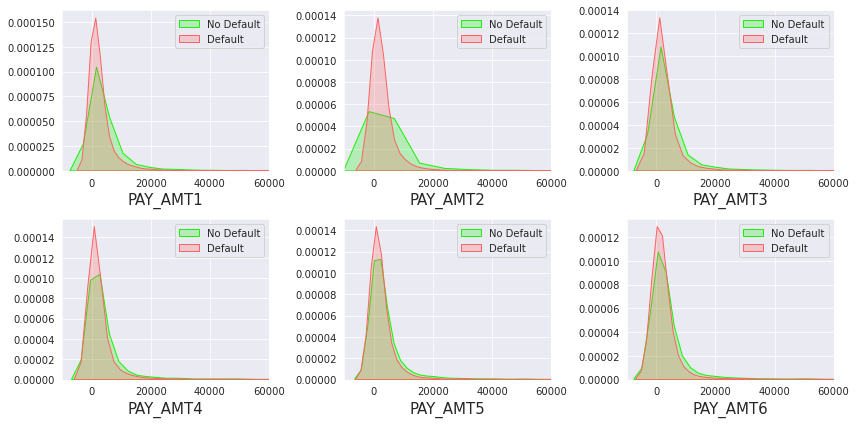

In [78]:
PAY_AMT_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
plt.figure(figsize=(12,6))

for i,col in enumerate(PAY_AMT_cols):    
    plt.subplot(2,3,i + 1)    
    sns.kdeplot(df.loc[(df['DEFAULT'] == 0), col], label = 'No Default', shade = True,color="#19F108")
    sns.kdeplot(df.loc[(df['DEFAULT'] == 1), col], label = 'Default', shade = True, color="#FF6363")
    plt.xlim(-10000,60000)
    plt.xlabel(col,fontsize=15)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()
    
plt.savefig('images/continuousPAYAMT.svg')
plt.show()

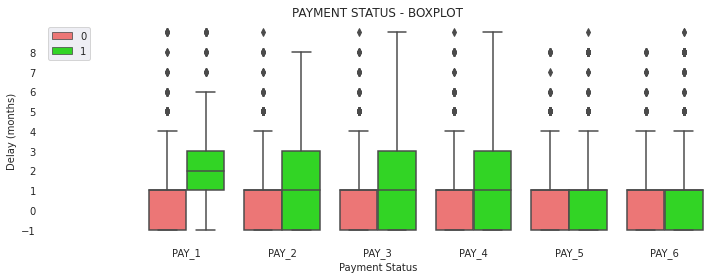

In [107]:
repayment = df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT']]
repayment = pd.melt(repayment, 
                    id_vars="DEFAULT",
                    var_name="Payment Status",
                    value_name='Delay (months)')

sns.set_color_codes('pastel')
plt.figure(figsize=(12,4))
sns.boxplot(y="Delay (months)", x="Payment Status", hue="DEFAULT", data=repayment, palette=sns.color_palette(('#FF6363', '#19F108')))
plt.xlim([-1.5,5.5])
plt.ylim([-1.5,9.5])
plt.yticks(np.arange(-1,9))
plt.title('PAYMENT STATUS - BOXPLOT')
plt.legend()
plt.savefig('images/BoxplotPAY.svg')
plt.box(False)

### 2.5 Normality check - QQ plot

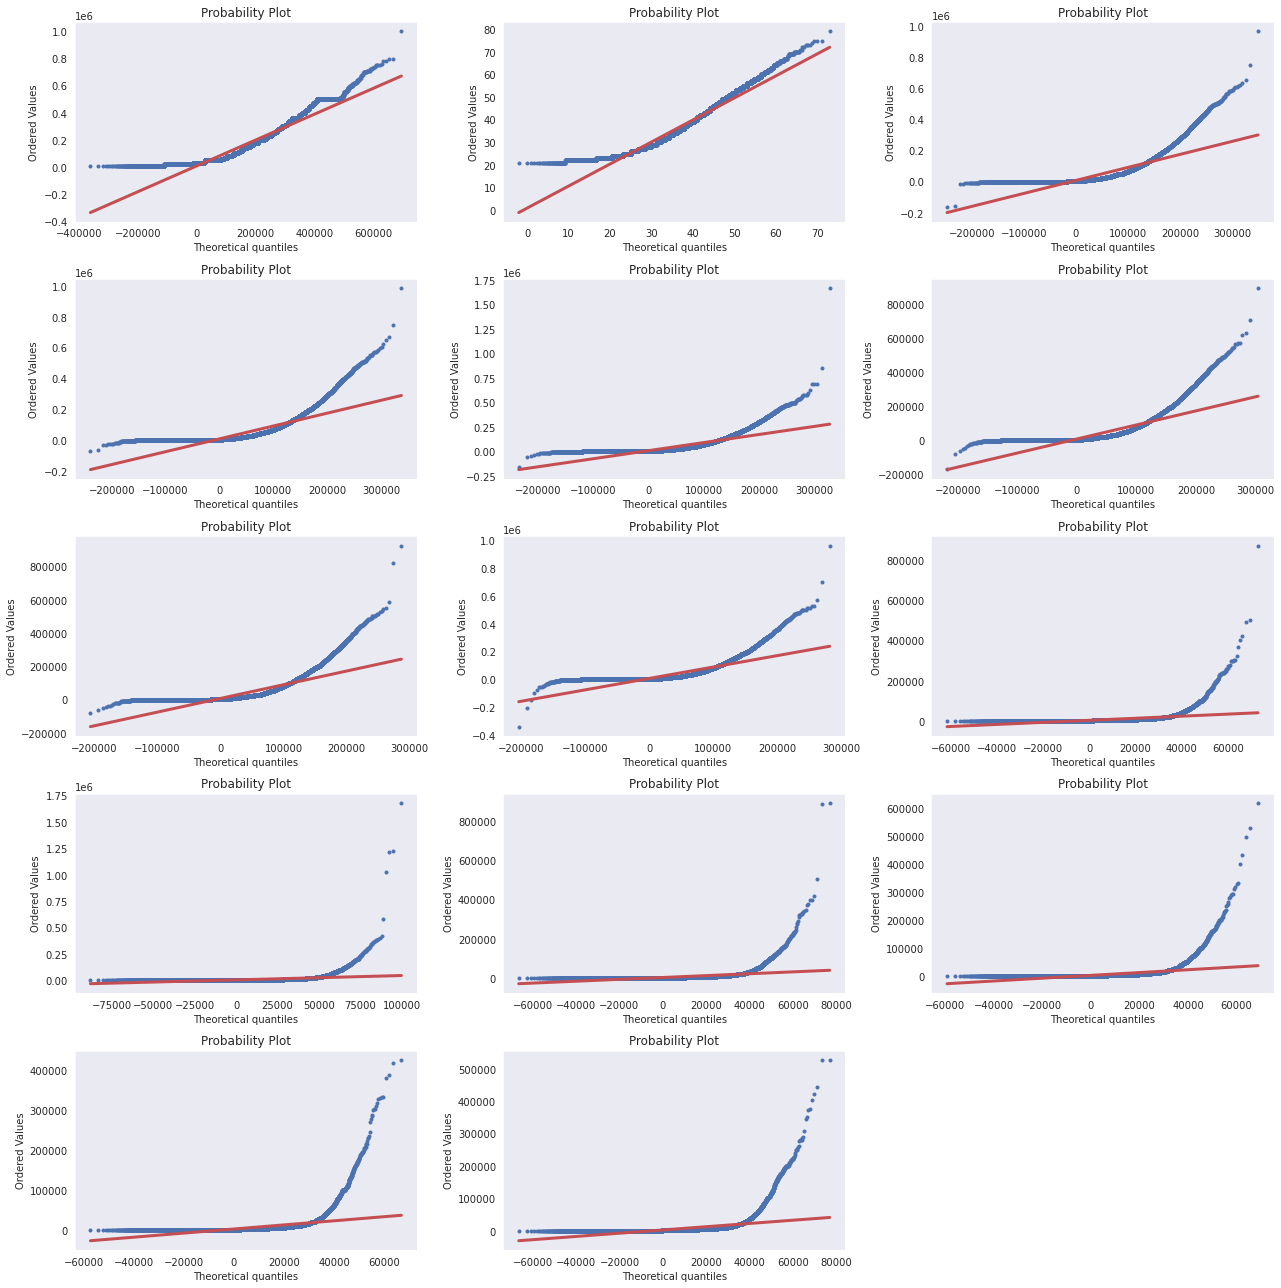

In [108]:
sns.set_color_codes('deep')
fig, axs = plt.subplots(5, 3, figsize=(18,18))

numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
i, j = 0, 0
for f in numeric:
    if j == 3:
        j = 0
        i = i+1
    stats.probplot(df[f], 
                   dist='norm', 
                   sparams=(df[f].mean(), df[f].std()), 
                   plot=axs[i,j])
    axs[i,j].get_lines()[0].set_marker('.')
    
    axs[i,j].grid()
    axs[i,j].get_lines()[1].set_linewidth(3.0)
    j = j+1

fig.tight_layout()
axs[4,2].set_visible(False)
plt.savefig('images/QQplot.png')
plt.show()

### 2.6 Correlation

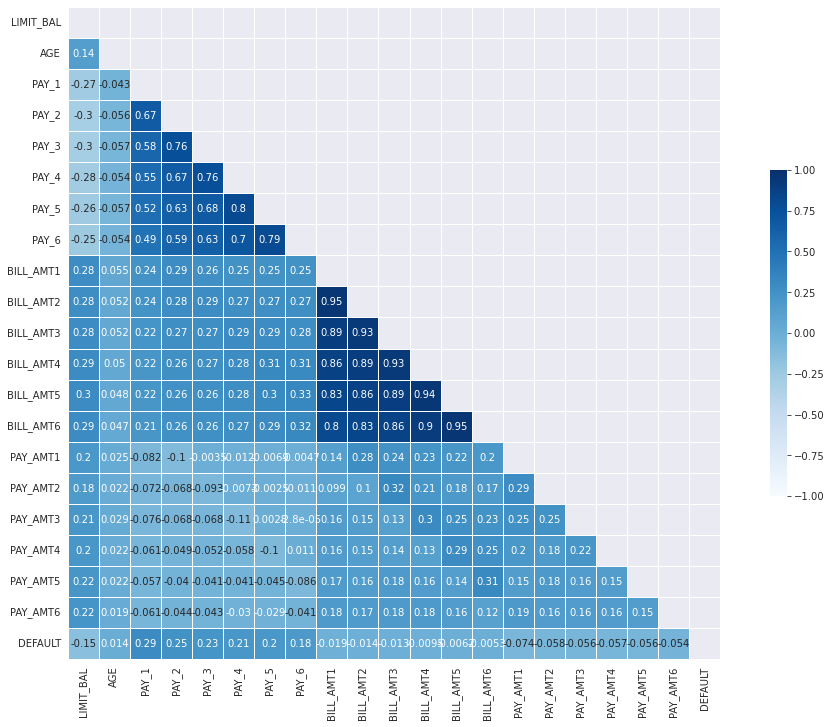

In [110]:
numeric = ['LIMIT_BAL','AGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6', 'DEFAULT']
corr = df[numeric].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18,12))
ax = sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cmap='Blues', cbar_kws={'shrink': .5}, annot=True, annot_kws={'size': 10})
plt.savefig('images/correlation.svg')
cbar = ax.collections[0].colorbar

### 2.7 Outliers

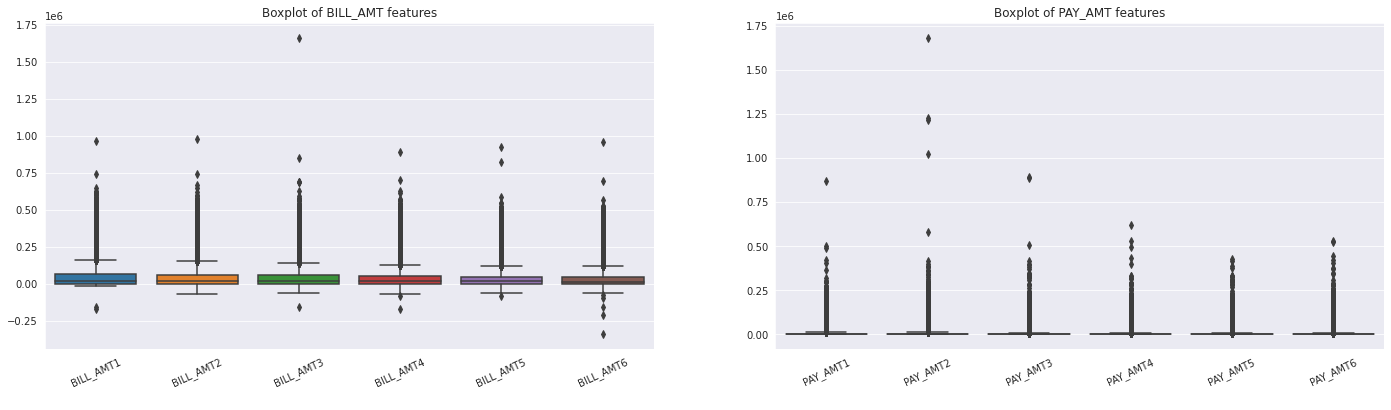

In [23]:
sns.set_color_codes('pastel')
bill_atm = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
pay_atm = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
fig, axs = plt.subplots(1, 2, figsize=(24,6))

sns.boxplot(data=df[bill_atm], ax=axs[0])
axs[0].set_title('Boxplot of BILL_AMT features')
axs[0].set_xticklabels(labels=bill_atm, rotation=25)
axs[0].set_xlabel(' ')

sns.boxplot(data=df[pay_atm], ax=axs[1])
axs[1].set_title('Boxplot of PAY_AMT features')
axs[1].set_xticklabels(labels=pay_atm, rotation=25)
axs[1].set_xlabel(' ')
fig.savefig("images/outliers.svg")

In [24]:
df.drop(df[df["BILL_AMT1"] > 1000000].index, inplace=True)
df.drop(df[df["BILL_AMT2"] > 1000000].index, inplace=True)
df.drop(df[df["BILL_AMT3"] > 1000000].index, inplace=True)
df.drop(df[df["BILL_AMT4"] > 1000000].index, inplace=True)
df.drop(df[df["BILL_AMT5"] > 1000000].index, inplace=True)
df.drop(df[df["BILL_AMT6"] > 1000000].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29600 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  29600 non-null  int64
 1   SEX        29600 non-null  int64
 2   EDUCATION  29600 non-null  int64
 3   MARRIAGE   29600 non-null  int64
 4   AGE        29600 non-null  int64
 5   PAY_1      29600 non-null  int64
 6   PAY_2      29600 non-null  int64
 7   PAY_3      29600 non-null  int64
 8   PAY_4      29600 non-null  int64
 9   PAY_5      29600 non-null  int64
 10  PAY_6      29600 non-null  int64
 11  BILL_AMT1  29600 non-null  int64
 12  BILL_AMT2  29600 non-null  int64
 13  BILL_AMT3  29600 non-null  int64
 14  BILL_AMT4  29600 non-null  int64
 15  BILL_AMT5  29600 non-null  int64
 16  BILL_AMT6  29600 non-null  int64
 17  PAY_AMT1   29600 non-null  int64
 18  PAY_AMT2   29600 non-null  int64
 19  PAY_AMT3   29600 non-null  int64
 20  PAY_AMT4   29600 non-null  int64
 21  PAY_AMT5   2

# 3. Data Preprocessing

## 3.1 Categorical Features Encoding

In [25]:
df['GRAD_SCHOOL'] = (df['EDUCATION'] == 1).astype('category')
df['UNIVERSITY'] = (df['EDUCATION'] == 2).astype('category')
df['HIGH_SCHOOL'] = (df['EDUCATION'] == 3).astype('category')
df.drop('EDUCATION', axis=1, inplace=True)

df['MALE'] = (df['SEX'] == 1).astype('category')
df.drop('SEX', axis=1, inplace=True)

df['MARRIED'] = (df['MARRIAGE'] == 1).astype('category')
df.drop('MARRIAGE', axis=1, inplace=True)

df.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,GRAD_SCHOOL,UNIVERSITY,HIGH_SCHOOL,MALE,MARRIED
0,20000,24,3,3,-1,-1,-1,-1,3913,3102,...,0,0,0,0,1,False,True,False,False,True
1,120000,26,-1,3,1,1,1,3,2682,1725,...,1000,1000,0,2000,1,False,True,False,False,False
2,90000,34,1,1,1,1,1,1,29239,14027,...,1000,1000,1000,5000,0,False,True,False,False,False
3,50000,37,1,1,1,1,1,1,46990,48233,...,1200,1100,1069,1000,0,False,True,False,False,True
4,50000,57,-1,1,-1,1,1,1,8617,5670,...,10000,9000,689,679,0,False,True,False,True,True


## 3.2 Dataset Partition

In [26]:
y = df['DEFAULT']
X = df.drop('DEFAULT', axis=1, inplace=False)

X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)
print('Training set shape: ', np.shape(X_train_original))
print(f'- Defaulters:\t {len(y_train[y_train==1])}')
print(f'- Non-defaulters: {len(y_train[y_train==0])}')
print('Test set shape: ', np.shape(X_test_original))
print(f'- Defaulters:\t {len(y_test[y_test==1])}')
print(f'- Non-defaulters: {len(y_test[y_test==0])}')

Training set shape:  (22200, 25)
- Defaulters:	 4954
- Non-defaulters: 17246
Test set shape:  (7400, 25)
- Defaulters:	 1651
- Non-defaulters: 5749


## 3.3 Features Scaling

In [27]:
#no normal distribution found -> no standardization
#normalized
scaler = MinMaxScaler()
X_train_normalized = X_train_original.copy()
X_test_normalized = X_test_original.copy()

X_train_normalized['LIMIT_BAL'] = scaler.fit_transform(X_train_original['LIMIT_BAL'].values.reshape(-1, 1))
X_test_normalized['LIMIT_BAL'] = scaler.transform(X_test_original['LIMIT_BAL'].values.reshape(-1, 1))
X_train_normalized['AGE'] = scaler.fit_transform(X_train_original['AGE'].values.reshape(-1, 1))
X_test_normalized['AGE'] = scaler.transform(X_test_original['AGE'].values.reshape(-1, 1))
for i in range(1,7):
    X_train_normalized['PAY_' + str(i)] = scaler.fit_transform(X_train_original['PAY_' + str(i)].values.reshape(-1, 1))
    X_test_normalized['PAY_' + str(i)] = scaler.transform(X_test_original['PAY_' + str(i)].values.reshape(-1, 1))
    X_train_normalized['BILL_AMT' + str(i)] = scaler.fit_transform(X_train_original['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_test_normalized['BILL_AMT' + str(i)] = scaler.transform(X_test_original['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_train_normalized['PAY_AMT' + str(i)] = scaler.fit_transform(X_train_original['PAY_AMT' + str(i)].values.reshape(-1, 1))
    X_test_normalized['PAY_AMT' + str(i)] = scaler.transform(X_test_original['PAY_AMT' + str(i)].values.reshape(-1, 1))

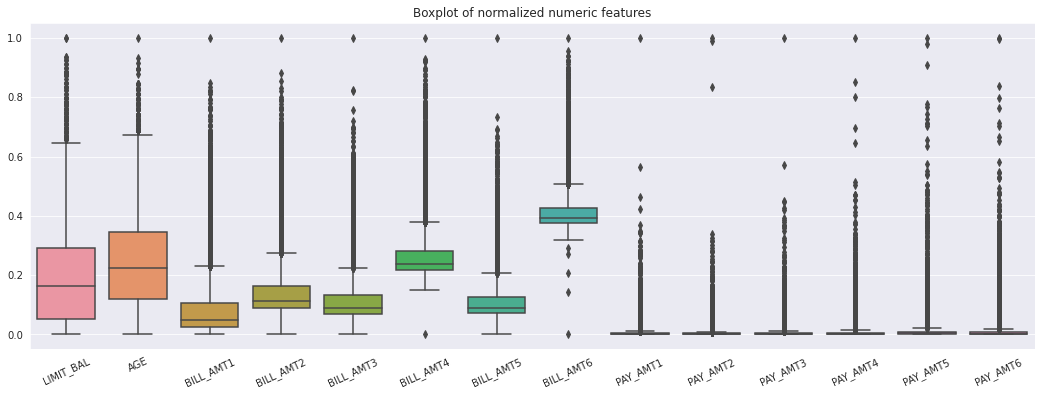

In [28]:
features = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

sns.set_color_codes('deep')
fig, axs = plt.subplots(figsize=(18,6))

sns.boxplot(data=X_train_normalized[features])
axs.set_title('Boxplot of normalized numeric features')
axs.set_xticklabels(labels=features, rotation=25)
axs.set_xlabel(' ')
plt.savefig('images/normalized.svg')
plt.show()

## 3.4 Dimensionality Reduction

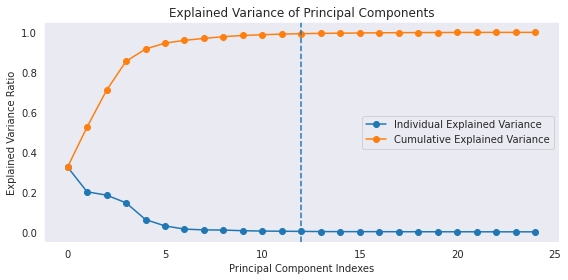

In [111]:
pc = len(X_train_normalized.columns.values) #number columns = 25
pca = PCA(n_components=pc)
pca.fit(X_train_normalized)

sns.set_color_codes('pastel')
plt.figure(figsize = (8,4))
plt.grid()
plt.title('Explained Variance of Principal Components')
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.legend(["Individual Explained Variance", "Cumulative Explained Variance"])
plt.xlabel('Principal Component Indexes')
plt.ylabel('Explained Variance Ratio')
plt.savefig("images/PCACumulative.svg")
plt.tight_layout()
plt.axvline(12, 0, ls='--')
plt.show()

In [30]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
indexes = ['PC' + str(i) for i in range(1, pc+1)]
cumsum_df = pd.DataFrame(data=cumsum, index=indexes, columns=['var1'])
cumsum_df['var2'] = pd.Series([round(val, 4) for val in cumsum_df['var1']], index = cumsum_df.index)
cumsum_df['Cumulative Explained Variance'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cumsum_df['var2']], index = cumsum_df.index)
cumsum_df = cumsum_df.drop(['var1','var2'], axis=1, inplace=False)
cumsum_df.T.iloc[:,:15]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
Cumulative Explained Variance,32.48%,52.55%,70.94%,85.49%,91.65%,94.62%,95.99%,96.98%,97.87%,98.44%,98.83%,99.13%,99.35%,99.50%,99.60%


In [31]:
pc = 12 # >99% explained variance
pca = PCA(n_components=pc)
pca.fit(X_train_normalized)

X_train = pd.DataFrame(pca.transform(X_train_normalized))
X_test = pd.DataFrame(pca.transform(X_test_normalized))
X_train.columns = ['PC' + str(i) for i in range(1, pc+1)]
X_test.columns = ['PC' + str(i) for i in range(1, pc+1)]
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-0.758793,0.332603,-0.342040,-0.290126,0.087361,-0.154921,0.069522,-0.031052,-0.042684,-0.004040,0.004302,0.001540
1,-0.504832,-0.504839,-0.471811,0.090821,-0.379773,0.014054,0.089817,-0.065653,0.150899,-0.150163,-0.079336,-0.036536
2,-0.713442,0.208602,0.640296,-0.378675,-0.060213,-0.109316,0.094713,-0.032922,0.092504,0.151247,-0.185831,0.066845
3,0.870313,-0.266718,-0.494532,-0.072750,-0.292046,-0.109804,0.097586,-0.145433,-0.091582,0.034173,0.003507,0.009543
4,-0.566956,-0.548768,-0.431691,0.178227,0.224742,-0.095265,0.078400,-0.066312,0.124640,0.109002,0.070864,-0.045018


## 3.5 Dealing with Class Imbalance

In [32]:
class_count = [y_train[y_train == 0].count(), y_train[y_train == 1].count()]
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number'])
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index)
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index)
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False)
print('Training set class proportion')
class_count_df

Training set class proportion


,Number,Percentage
Non-defaulters,17246,77.68%
Defaulters,4954,22.32%


### 3.5.1 Cluster Centroid Undersampling

In [33]:
undersample = ClusterCentroids(random_state=42)
X_train_cc, y_train_cc = undersample.fit_resample(X_train, y_train)

class_count = [y_train_cc[y_train_cc == 0].count(), y_train_cc[y_train_cc == 1].count()]
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number'])
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index)
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index)
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False)
print('Training set class proportion after Cluster Centroid Undersampling')
class_count_df

# non-defaulters 4954
# defaulters 4954

Training set class proportion after Cluster Centroid Undersampling


,Number,Percentage
Non-defaulters,4954,50.00%
Defaulters,4954,50.00%


### 3.5.2 Synthetic Minority Oversampling Technique (SMOTE)

In [34]:
oversample = SMOTE(random_state=42)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

class_count = [y_train_smote[y_train_smote == 0].count(), y_train_smote[y_train_smote == 1].count()]
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number'])
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index)
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index)
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False)
print('Training set class proportion after SMOTE Oversampling')
class_count_df

# non-defaulters 17246
# defaulters 17246

Training set class proportion after SMOTE Oversampling


,Number,Percentage
Non-defaulters,17246,50.00%
Defaulters,17246,50.00%


### 3.5.3 K-means SMOTE

In [35]:
oversample = KMeansSMOTE(cluster_balance_threshold=0.00001, random_state=42)
X_train_ksmote, y_train_ksmote = oversample.fit_resample(X_train, y_train)

class_count = [y_train_ksmote[y_train_ksmote == 0].count(), y_train_ksmote[y_train_ksmote == 1].count()]
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number'])
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index)
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index)
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False)
print('Training set class proportion after K-means SMOTE Oversampling')
class_count_df

# non-defaulters 17246
# defaulters 17251

Training set class proportion after K-means SMOTE Oversampling


,Number,Percentage
Non-defaulters,17246,49.99%
Defaulters,17251,50.01%


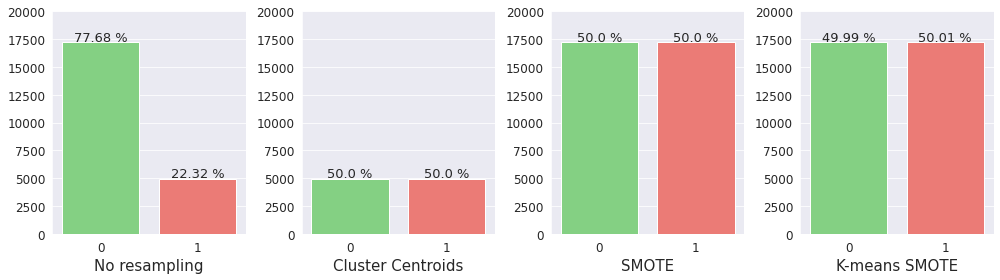

In [36]:
y_list = [y_train, y_train_cc, y_train_smote, y_train_ksmote]
y_list_labels = ['No resampling', 'Cluster Centroids', 'SMOTE', 'K-means SMOTE']

plt.figure(figsize=(14,4))

i = 1
for value, label in zip(y_list,y_list_labels):    
    plt.subplot(1,4,i)
    graph_target = sns.countplot(value, palette=['#77DD76','#FF6962']) 
    plt.xlabel(label, fontdict= {"size":15})
    plt.ylabel('')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    j=0
    for p in graph_target.patches:
        height = p.get_height()

        str_plot = f'{round(100 * value.value_counts()[j]/len(value),2)} %'

        graph_target.text(p.get_x()+p.get_width()/2., height + 100 , str_plot, ha="center", fontsize = 13)
        j += 1
        
    i += 1
    graph_target.set_ylim(0, 20000) 

plt.tight_layout()
plt.savefig('images/resamplingDataset.svg')
plt.show()

# 4. Model Evaluation Methodology

In [37]:
def test_scores_plot(model, resampling):
    if resampling == 'original':
        X_test_s = X_test_normalized.copy() #without PCA
    else:
        X_test_s = X_test.copy() #with PCA
    
    # predict
    y_pred = model.predict(X_test_s)

    # various tests
    test_acc = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    test_auc = auc(recall, precision)
    test_f1 = f1_score(y_test, y_pred)
    
    #print on console
    print("Test Scores:")
    print(f"- Accuracy:\t{test_acc}")
    print(f"- Recall:\t{test_recall}")
    print(f"- Precision:\t{test_precision}")
    print(f"- F1-score:\t{test_f1}")
    print(f"- AUC:\t\t{test_auc}")
    
    #plot results
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    plot_confusion_matrix(model, X_test_s, y_test, 
                          cmap=plt.cm.Greens, 
                          normalize='true', 
                          ax=axs[0])
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plot_precision_recall_curve(model, X_test_s, y_test, ax=axs[1])
    plt.axhline(no_skill, 0, ls='--', label='No Skill')
    plt.ylim([-0.05, 1.05])
    axs[1].legend(loc = 'upper right')
    plt.show()
    
    return test_acc, test_recall, test_precision, test_f1, test_auc

def pipeline(model, params, resampling=None):
    
    max_f1 = 0
    y_pred_max = 0
    y_test_max = 0
    
    if resampling:
        if resampling == 'original': #without PCA
            X_train_s = X_train_normalized.copy() #original data scaled
            y_train_s = y_train.copy()  
            X_test_f1 = X_test_original.copy()
        else:                        
            X_train_s, y_train_s = resampling.fit_resample(X_train, y_train) #with PCA and resampling
            X_test_f1 = X_test.copy() 
    else:
        X_train_s = X_train.copy() #with PCA without resampling
        y_train_s = y_train.copy()
        X_test_f1 = X_test.copy()
    
    #gridsearch best parameter
    gridsearch = GridSearchCV(estimator = model,
                      param_grid = params,
                      scoring = 'f1',
                      cv = 5, 
                      n_jobs = -1,
                      verbose = True)
    gridsearch.fit(X_train_s, y_train_s)
    print(f"Best parameters:\t{gridsearch.best_params_}")
    print(f"Best validation score:\t{gridsearch.best_score_}")
    
    test_scores = test_scores_plot(gridsearch, resampling) #ritorna tupla con risultati test
    
    best_estimator = gridsearch.best_estimator_
    
    # save best config
    y_pred = best_estimator.predict(X_test_f1)
    f1 = round(f1_score(y_test, y_pred),2)

    if f1 > max_f1:
        y_pred_max = y_pred
        y_test_max = y_test
        max_f1 = f1
            
    return test_scores, y_pred_max, y_test_max

In [38]:
# Plots a barchart with the F1 results and a confusion matrix on the best estimator with the best preprocessing technique
def plot_summary(result, resampling_names, y_pred, y_test):
    
    fig = plt.figure(constrained_layout=False,figsize=(14,4))
    gs1 = fig.add_gridspec(nrows=1, ncols=6, left=0.1, right=0.90, wspace=0.5, hspace=0.5)
    ax1 = fig.add_subplot(gs1[0,0:3])
    ax2 = fig.add_subplot(gs1[0,3:5])
    
    plot_x = []
    plot_y = []
    
    for i in range(len(result)):
        plot_x.append(result[i])
        plot_y.append(resampling_names[i])

    temp_df = pd.DataFrame({'x':plot_x, 'y':plot_y}).sort_values(['x'], ascending=False)
    
    # plot barchart
    sns.barplot(data=temp_df, x='x',y='y', 
                palette='Greens_r',
                ax=ax1)
    ax1.set_xlabel("F1-score", fontsize="14")
    ax1.set_ylabel("")
    ax1.set_yticklabels(temp_df.y,fontsize=13)
    
    # confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, 
                cmap=plt.cm.Greens, 
                annot_kws={"size": 14},
                linecolor = 'w',
                linewidth = 4,ax=ax2,
                fmt='d'
               )
    
    ax2.set_xlabel("Predicted labels",fontsize="14")
    ax2.set_ylabel("True labels",fontsize="14")
    
    return plt

In [39]:
resampling_method = ['original',  #training untouched
                     None,        #Only PCA on training
                     SMOTE(random_state=42), #PCA and SMOTE resampling on training
                     KMeansSMOTE(cluster_balance_threshold=1e-5, random_state=42), #PCA and Kmeans SMOTE oversampling on training
                     ClusterCentroids(random_state=42) #PCA and Cluster Centroid undersampling on training
                    ]
resampling_names = ['Original data', 
                    'PCA', 
                    'PCA + SMOTE oversampling', 
                    'PCA + KMeansSMOTE oversampling', 
                    'PCA + ClusterCentroids undersampling'
                   ]

### 4.1 Logistic Regression

Logistic Regression using Original data
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 100.0}
Best validation score:	0.2766303037040837
Test Scores:
- Accuracy:	0.8059459459459459
- Recall:	0.1913991520290733
- Precision:	0.7577937649880095
- F1-score:	0.3056092843326886
- AUC:		0.5647991612112442


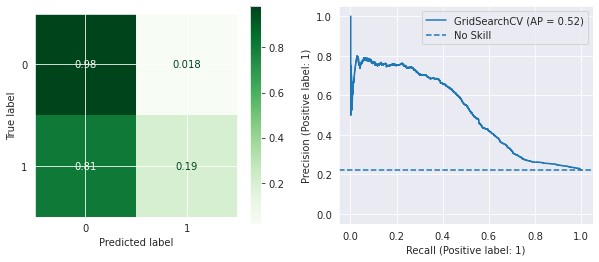

Logistic Regression using PCA
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 100.0}
Best validation score:	0.2710935684279457
Test Scores:
- Accuracy:	0.8054054054054054
- Recall:	0.18958207147183526
- Precision:	0.7542168674698795
- F1-score:	0.303000968054211
- AUC:		0.5623048748762628


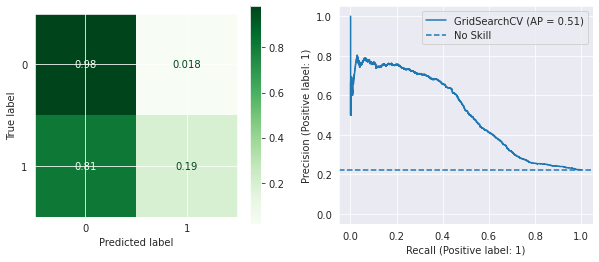

Logistic Regression using PCA + SMOTE oversampling
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 100.0}
Best validation score:	0.6630131847621497
Test Scores:
- Accuracy:	0.6327027027027027
- Recall:	0.6729254996971532
- Precision:	0.3377926421404682
- F1-score:	0.44979757085020244
- AUC:		0.5418455574052972


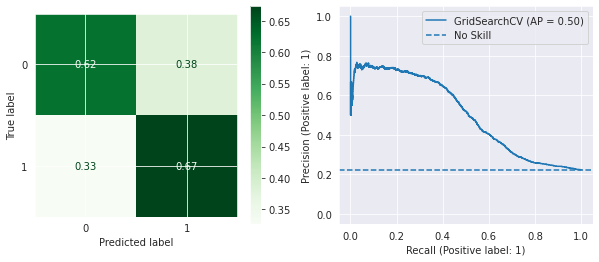

Logistic Regression using PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 1.0}
Best validation score:	0.7340137074981176
Test Scores:
- Accuracy:	0.72
- Recall:	0.3615990308903695
- Precision:	0.3696594427244582
- F1-score:	0.3655848132271892
- AUC:		0.43684545302363004


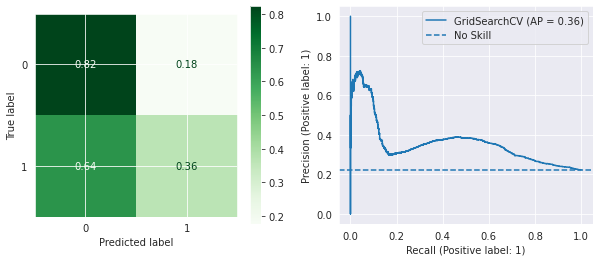

Logistic Regression using PCA + ClusterCentroids undersampling
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 100.0}
Best validation score:	0.6523160459922017
Test Scores:
- Accuracy:	0.6028378378378378
- Recall:	0.6698970321017566
- Precision:	0.316
- F1-score:	0.4294311784119588
- AUC:		0.5297728403752027


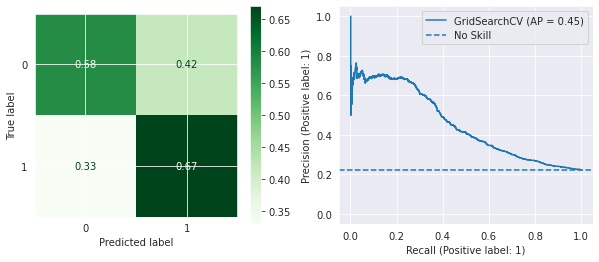

,Accuracy,Recall,Precision,F1-score,AUC
Original data,0.805946,0.191399,0.757794,0.305609,0.564799
PCA,0.805405,0.189582,0.754217,0.303001,0.562305
PCA + SMOTE oversampling,0.632703,0.672925,0.337793,0.449798,0.541846
PCA + KMeansSMOTE oversampling,0.720000,0.361599,0.369659,0.365585,0.436845
PCA + ClusterCentroids undersampling,0.602838,0.669897,0.316000,0.429431,0.529773


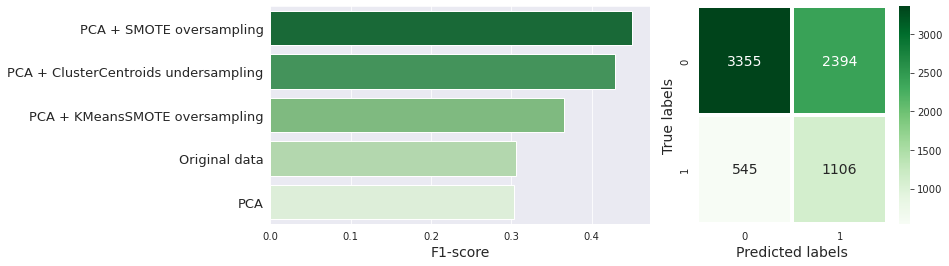

In [40]:
#Dictionary with all scores over differnt approaches
scores_logReg = {'Accuracy' : [float for i in range(len(resampling_method))],
                 'Recall' : [float for i in range(len(resampling_method))],
                 'Precision' : [float for i in range(len(resampling_method))], 
                 'F1-score' : [float for i in range(len(resampling_method))],
                 'AUC' : [float for i in range(len(resampling_method))],}

params_logReg = {'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]} #parameters for GridSearch

for idx, resampling in enumerate(resampling_method):
    print(f"Logistic Regression using {resampling_names[idx]}")
    
    scores, y_pred_max, y_test_max = pipeline(LogisticRegression(random_state=42, max_iter=400), 
                                              params_logReg, 
                                              resampling)
    
    scores_logReg['Accuracy'][idx] = scores[0]
    scores_logReg['Recall'][idx] = scores[1]
    scores_logReg['Precision'][idx] = scores[2]
    scores_logReg['F1-score'][idx] = scores[3]
    scores_logReg['AUC'][idx] = scores[4]
    
scores_logReg_df = pd.DataFrame(data=scores_logReg, index=resampling_names)
plot = plot_summary(scores_logReg["F1-score"], resampling_names, y_pred_max, y_test_max)
plot.savefig("images/summaryLogReg.svg")
scores_logReg_df

### 4.2 Support vector machine

Support Vector Machine using Original data
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Best validation score:	0.4484229675919872
Test Scores:
- Accuracy:	0.8251351351351351
- Recall:	0.34463961235614776
- Precision:	0.7285531370038413
- F1-score:	0.46792763157894735
- AUC:		0.6097044827881026


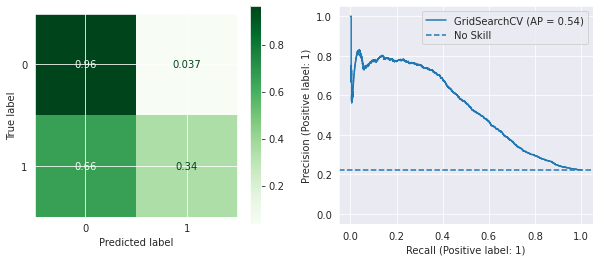

Support Vector Machine using PCA
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Best validation score:	0.44817088262153615
Test Scores:
- Accuracy:	0.8252702702702702
- Recall:	0.3470623864324652
- Precision:	0.7271573604060914
- F1-score:	0.4698646986469865
- AUC:		0.6099477112571161


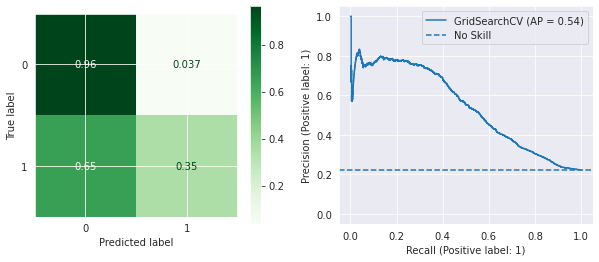

Support Vector Machine using PCA + SMOTE oversampling
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 10.0, 'gamma': 'scale', 'kernel': 'poly'}
Best validation score:	0.6759866235267189
Test Scores:
- Accuracy:	0.6890540540540541
- Recall:	0.6480920654149
- Precision:	0.3835125448028674
- F1-score:	0.4818734519252421
- AUC:		0.5550590618656405


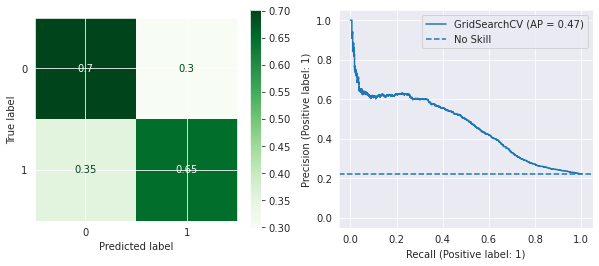

Support Vector Machine using PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation score:	0.7597105497815029
Test Scores:
- Accuracy:	0.7481081081081081
- Recall:	0.48697758933979407
- Precision:	0.4415156507413509
- F1-score:	0.4631336405529954
- AUC:		0.5214763497703022


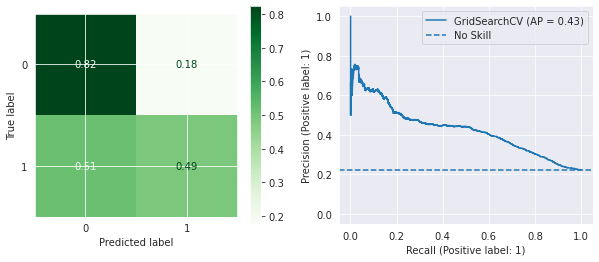

Support Vector Machine using PCA + ClusterCentroids undersampling
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation score:	0.6912921748914372
Test Scores:
- Accuracy:	0.5755405405405405
- Recall:	0.7419745608721987
- Precision:	0.31091370558375636
- F1-score:	0.43820425684135217
- AUC:		0.5552279170117613


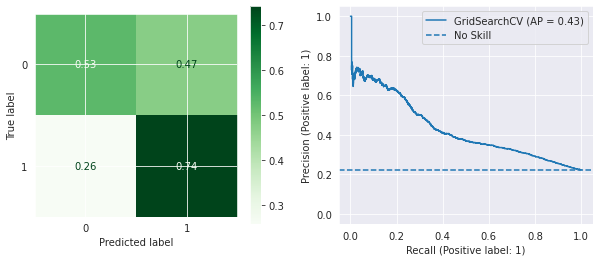

,Accuracy,Recall,Precision,F1-score,AUC
Original data,0.825135,0.344640,0.728553,0.467928,0.609704
PCA,0.825270,0.347062,0.727157,0.469865,0.609948
PCA + SMOTE oversampling,0.689054,0.648092,0.383513,0.481873,0.555059
PCA + KMeansSMOTE oversampling,0.748108,0.486978,0.441516,0.463134,0.521476
PCA + ClusterCentroids undersampling,0.575541,0.741975,0.310914,0.438204,0.555228


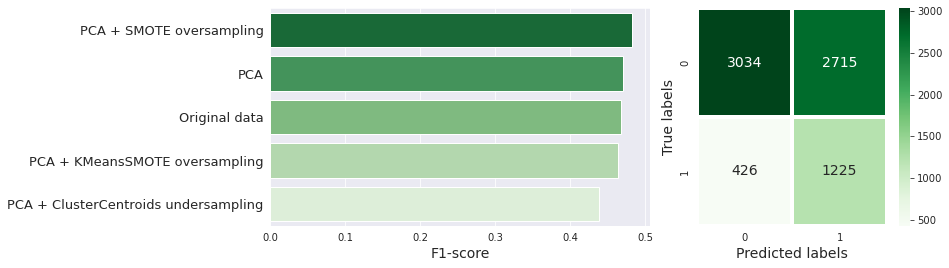

In [41]:
#Dictionary with all scores over differnt approaches
scores_SVM = {'Accuracy' : [float for i in range(len(resampling_method))],
                 'Recall' : [float for i in range(len(resampling_method))],
                 'Precision' : [float for i in range(len(resampling_method))], 
                 'F1-score' : [float for i in range(len(resampling_method))],
                 'AUC' : [float for i in range(len(resampling_method))],}

params_svm = {'C': [1e-1, 1e0, 1e1, 1e2], 
              'kernel': ['rbf', 'poly'],  #parameters for GridSearch
              'gamma': [1e-1, 'scale']}

for idx, resampling in enumerate(resampling_method):
    print(f"Support Vector Machine using {resampling_names[idx]}")
    scores, y_pred_max, y_test_max = pipeline(SVC(),
                                             params_svm,
                                             resampling)
    scores_SVM['Accuracy'][idx] = scores[0]
    scores_SVM['Recall'][idx] = scores[1]
    scores_SVM['Precision'][idx] = scores[2]
    scores_SVM['F1-score'][idx] = scores[3]
    scores_SVM['AUC'][idx] = scores[4]
    
scores_SVM_df = pd.DataFrame(data=scores_SVM, index=resampling_names)
plot = plot_summary(scores_SVM["F1-score"], resampling_names, y_pred_max, y_test_max)
plot.savefig("images/summarySVM.svg")
scores_SVM_df

### 4.3 Decision tree

Decision Tree using Original data
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 5}
Best validation score:	0.4608124615577295
Test Scores:
- Accuracy:	0.8241891891891892
- Recall:	0.37129012719563903
- Precision:	0.6997716894977168
- F1-score:	0.4851602690937871
- AUC:		0.6056660434818131


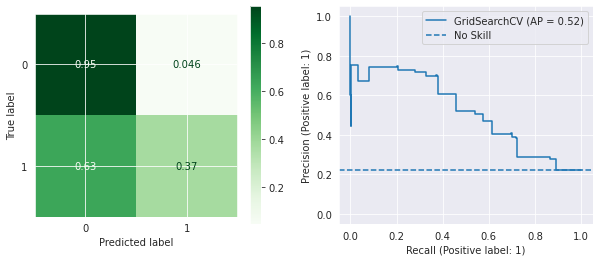

Decision Tree using PCA
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 10}
Best validation score:	0.4294749106668509
Test Scores:
- Accuracy:	0.8031081081081081
- Recall:	0.3603876438522108
- Precision:	0.5973895582329317
- F1-score:	0.44956554590102
- AUC:		0.5502399523939225


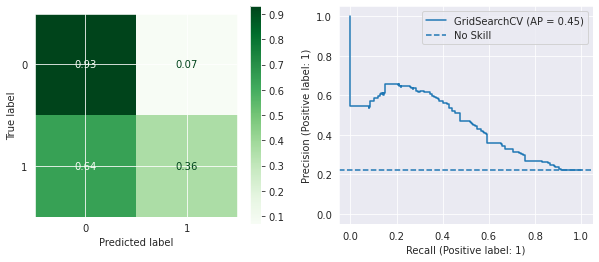

Decision Tree using PCA + SMOTE oversampling
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 50}
Best validation score:	0.7572765086799693
Test Scores:
- Accuracy:	0.687972972972973
- Recall:	0.4730466384009691
- Precision:	0.3518018018018018
- F1-score:	0.40351330405579955
- AUC:		0.47120800388516926


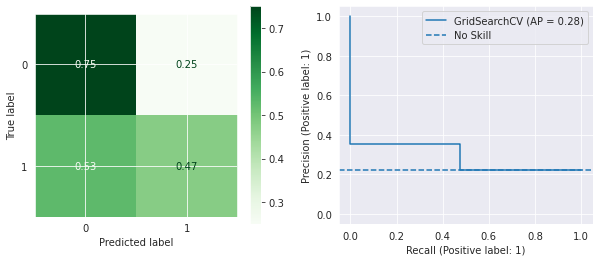

Decision Tree using PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 20}
Best validation score:	0.7837799115577633
Test Scores:
- Accuracy:	0.7333783783783784
- Recall:	0.4306480920654149
- Precision:	0.4076834862385321
- F1-score:	0.4188512518409426
- AUC:		0.482679302665487


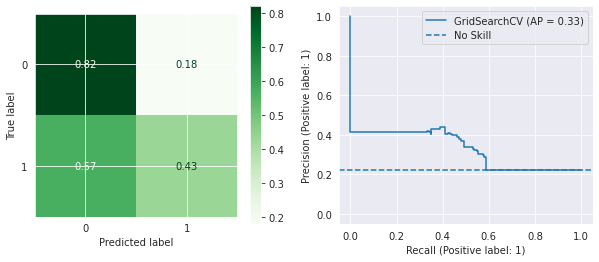

Decision Tree using PCA + ClusterCentroids undersampling
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 10}
Best validation score:	0.6563734269557988
Test Scores:
- Accuracy:	0.4833783783783784
- Recall:	0.681405208964264
- Precision:	0.2544097693351425
- F1-score:	0.3704923431582414
- AUC:		0.5034480296902438


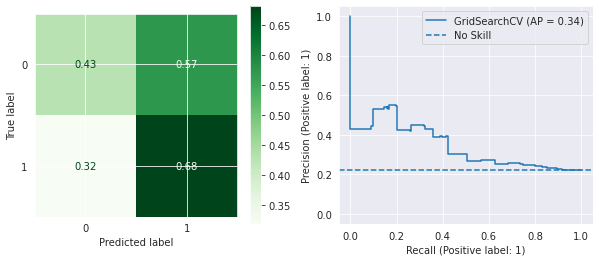

,Accuracy,Recall,Precision,F1-score,AUC
Original data,0.824189,0.371290,0.699772,0.485160,0.605666
PCA,0.803108,0.360388,0.597390,0.449566,0.550240
PCA + SMOTE oversampling,0.687973,0.473047,0.351802,0.403513,0.471208
PCA + KMeansSMOTE oversampling,0.733378,0.430648,0.407683,0.418851,0.482679
PCA + ClusterCentroids undersampling,0.483378,0.681405,0.254410,0.370492,0.503448


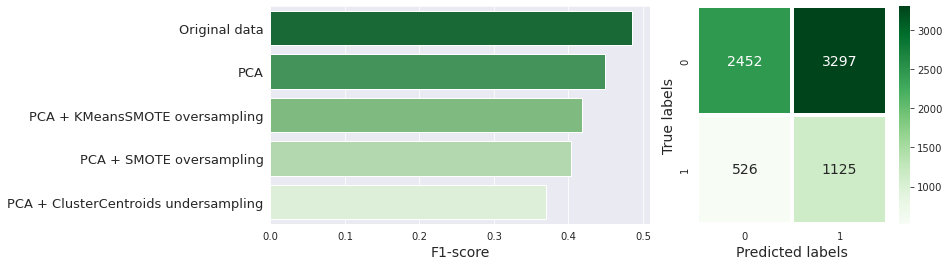

In [42]:
scores_Tree = {'Accuracy' : [float for i in range(len(resampling_method))],
             'Recall' : [float for i in range(len(resampling_method))],
             'Precision' : [float for i in range(len(resampling_method))], 
             'F1-score' : [float for i in range(len(resampling_method))],
             'AUC' : [float for i in range(len(resampling_method))],}

params_Tree = {'max_depth': [5, 10, 20, 30, 50]} #parameters for GridSearch

for idx, resampling in enumerate(resampling_method):
    print(f"Decision Tree using {resampling_names[idx]}")
    scores, y_pred_max, y_test_max = pipeline(DecisionTreeClassifier(criterion='entropy', max_features=None, random_state=24),
                                                     params_Tree,
                                                     resampling)
    scores_Tree['Accuracy'][idx] = scores[0]
    scores_Tree['Recall'][idx] = scores[1]
    scores_Tree['Precision'][idx] = scores[2]
    scores_Tree['F1-score'][idx] = scores[3]
    scores_Tree['AUC'][idx] = scores[4]
    
scores_Tree_df = pd.DataFrame(data=scores_Tree, index=resampling_names)
plot = plot_summary(scores_Tree["F1-score"], resampling_names, y_pred_max, y_test_max)
plot.savefig("images/summaryTree.svg")
scores_Tree_df

### 4.4 Random forest

Random Forest using Original data
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': None, 'n_estimators': 200}
Best validation score:	0.4691387306634958
Test Scores:
- Accuracy:	0.8191891891891891
- Recall:	0.3827983040581466
- Precision:	0.6645636172450052
- F1-score:	0.48578016910069177
- AUC:		0.5925323120029272


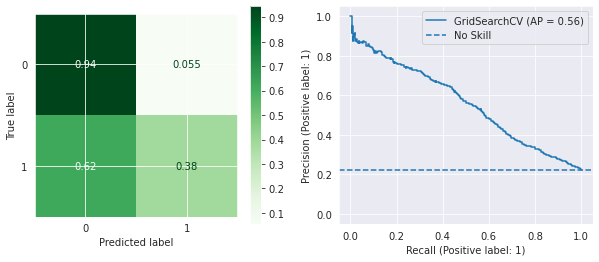

Random Forest using PCA
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': 'sqrt', 'n_estimators': 200}
Best validation score:	0.44702209778929225
Test Scores:
- Accuracy:	0.8110810810810811
- Recall:	0.3700787401574803
- Precision:	0.630546955624355
- F1-score:	0.46641221374045805
- AUC:		0.570583118161188


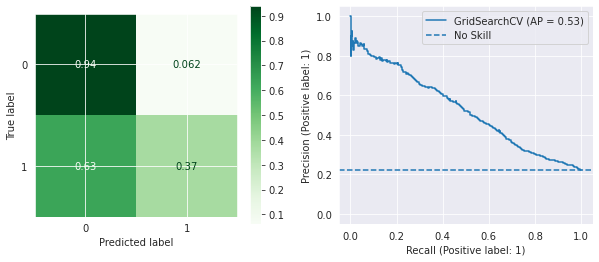

Random Forest using PCA + SMOTE oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': 'sqrt', 'n_estimators': 200}
Best validation score:	0.8357982747130059
Test Scores:
- Accuracy:	0.7620270270270271
- Recall:	0.5130224106602059
- Precision:	0.4695121951219512
- F1-score:	0.4903039073806078
- AUC:		0.5455916272154029


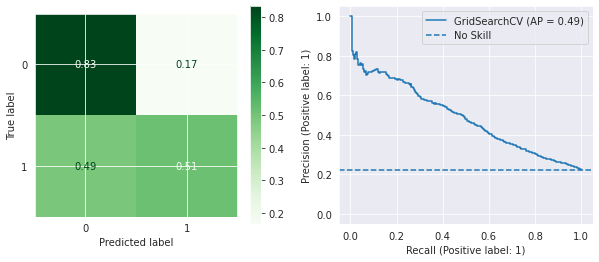

Random Forest using PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': None, 'n_estimators': 100}
Best validation score:	0.8134872642534342
Test Scores:
- Accuracy:	0.7848648648648648
- Recall:	0.42459115687462146
- Precision:	0.5219657483246463
- F1-score:	0.4682698730794923
- AUC:		0.5374676417888231


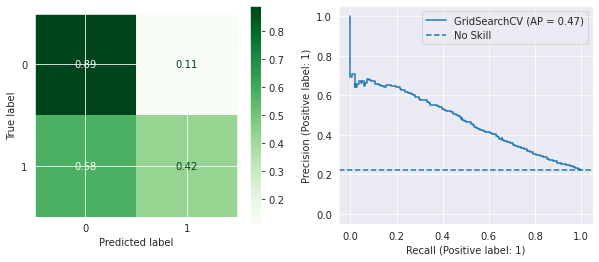

Random Forest using PCA + ClusterCentroids undersampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': 'sqrt', 'n_estimators': 200}
Best validation score:	0.668390801018034
Test Scores:
- Accuracy:	0.5867567567567568
- Recall:	0.677771047849788
- Precision:	0.3069958847736626
- F1-score:	0.422583081570997
- AUC:		0.5283294122576712


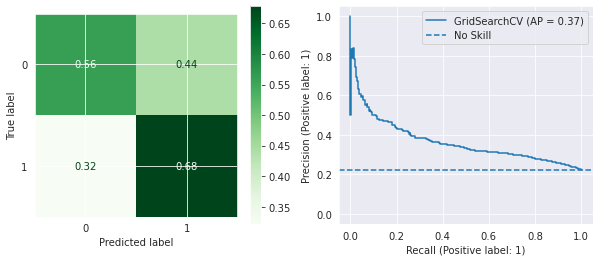

,Accuracy,Recall,Precision,F1-score,AUC
Original data,0.819189,0.382798,0.664564,0.485780,0.592532
PCA,0.811081,0.370079,0.630547,0.466412,0.570583
PCA + SMOTE oversampling,0.762027,0.513022,0.469512,0.490304,0.545592
PCA + KMeansSMOTE oversampling,0.784865,0.424591,0.521966,0.468270,0.537468
PCA + ClusterCentroids undersampling,0.586757,0.677771,0.306996,0.422583,0.528329


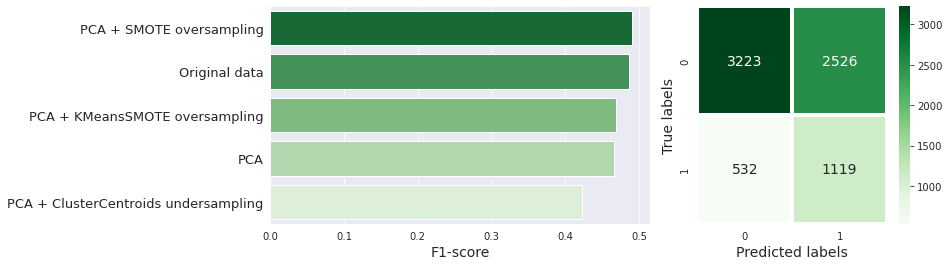

In [43]:
scores_RF = {'Accuracy' : [float for i in range(len(resampling_method))],
             'Recall' : [float for i in range(len(resampling_method))],
             'Precision' : [float for i in range(len(resampling_method))], 
             'F1-score' : [float for i in range(len(resampling_method))],
             'AUC' : [float for i in range(len(resampling_method))],}

params_RF = {'n_estimators': [10, 50, 100, 200],  #parameters for GridSearch
             'max_features': [None, 'sqrt']}

for idx, resampling in enumerate(resampling_method):
    print(f"Random Forest using {resampling_names[idx]}")
    scores, y_pred_max, y_test_max = pipeline(RandomForestClassifier(criterion='entropy', random_state=24, n_jobs=-1),
                                             params_RF,
                                             resampling)
    scores_RF['Accuracy'][idx] = scores[0]
    scores_RF['Recall'][idx] = scores[1]
    scores_RF['Precision'][idx] = scores[2]
    scores_RF['F1-score'][idx] = scores[3]
    scores_RF['AUC'][idx] = scores[4]
    
scores_RF_df = pd.DataFrame(data=scores_RF, index=resampling_names)
plot = plot_summary(scores_RF["F1-score"], resampling_names, y_pred_max, y_test_max)
plot.savefig("images/summaryRF.svg")
scores_RF_df

### 5 Models' Performance Results

In [44]:
frames = [scores_logReg_df, scores_SVM_df, scores_Tree_df, scores_RF_df]
scores_df = pd.concat(frames, keys=['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest'])
scores_df

Accuracy  \
Logistic Regression    Original data                         0.805946   
                       PCA                                   0.805405   
                       PCA + SMOTE oversampling              0.632703   
                       PCA + KMeansSMOTE oversampling        0.720000   
                       PCA + ClusterCentroids undersampling  0.602838   
Support Vector Machine Original data                         0.825135   
                       PCA                                   0.825270   
                       PCA + SMOTE oversampling              0.689054   
                       PCA + KMeansSMOTE oversampling        0.748108   
                       PCA + ClusterCentroids undersampling  0.575541   
Decision Tree          Original data                         0.824189   
                       PCA                                   0.803108   
                       PCA + SMOTE oversampling              0.687973   
                       PCA + KMeansSMOTE oversampling        0.733378   
                       PCA + ClusterCentroids undersampling  0.483378   
Random Forest          Original data                         0.819189   
                       PCA                                   0.811081   
                       PCA + SMOTE oversampling              0.762027   
                       PCA + KMeansSMOTE oversampling        0.784865   
                       PCA + ClusterCentroids undersampling  0.586757   

                                                               Recall  \
Logistic Regression    Original data                         0.191399   
                       PCA                                   0.189582   
                       PCA + SMOTE oversampling              0.672925   
                       PCA + KMeansSMOTE oversampling        0.361599   
                       PCA + ClusterCentroids undersampling  0.669897   
Support Vector Machine Original data                         0.344640   
                       PCA                                   0.347062   
                       PCA + SMOTE oversampling              0.648092   
                       PCA + KMeansSMOTE oversampling        0.486978   
                       PCA + ClusterCentroids undersampling  0.741975   
Decision Tree          Original data                         0.371290   
                       PCA                                   0.360388   
                       PCA + SMOTE oversampling              0.473047   
                       PCA + KMeansSMOTE oversampling        0.430648   
                       PCA + ClusterCentroids undersampling  0.681405   
Random Forest          Original data                         0.382798   
                       PCA                                   0.370079   
                       PCA + SMOTE oversampling              0.513022   
                       PCA + KMeansSMOTE oversampling        0.424591   
                       PCA + ClusterCentroids undersampling  0.677771   

                                                             Precision  \
Logistic Regression    Original data                          0.757794   
                       PCA                                    0.754217   
                       PCA + SMOTE oversampling               0.337793   
                       PCA + KMeansSMOTE oversampling         0.369659   
                       PCA + ClusterCentroids undersampling   0.316000   
Support Vector Machine Original data                          0.728553   
                       PCA                                    0.727157   
                       PCA + SMOTE oversampling               0.383513   
                       PCA + KMeansSMOTE oversampling         0.441516   
                       PCA + ClusterCentroids undersampling   0.310914   
Decision Tree          Original data                          0.699772   
                       PCA                                    0.597390   
                       PCA + SM

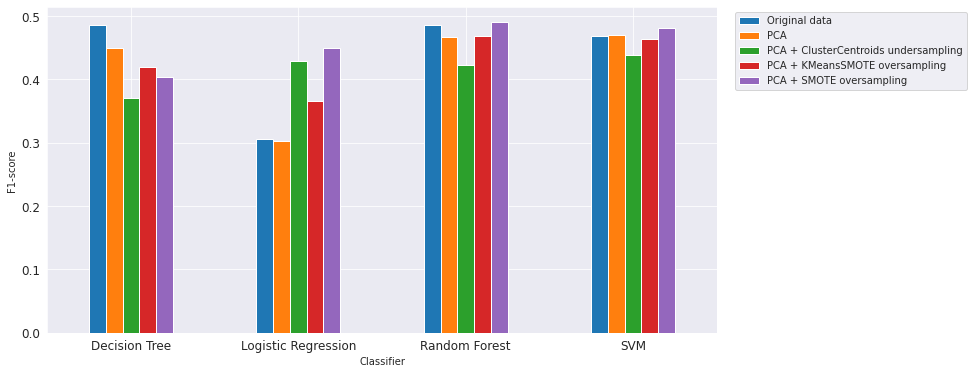

In [45]:
scores_logReg_df['Classifier'] = 'Logistic Regression'
scores_logReg_df['Technique'] = scores_logReg_df.index

scores_SVM_df['Classifier'] = 'SVM'
scores_SVM_df['Technique'] = scores_SVM_df.index

scores_Tree_df['Classifier'] = 'Decision Tree'
scores_Tree_df['Technique'] = scores_Tree_df.index

scores_RF_df['Classifier'] = 'Random Forest'
scores_RF_df['Technique'] = scores_RF_df.index

frames2 = [scores_logReg_df, scores_SVM_df, scores_Tree_df, scores_RF_df]
scores = pd.concat(frames2, ignore_index=True, keys=None)

scores.set_index(['Technique', 'Classifier']).unstack(0).plot(kind='bar', 
                                                              y='F1-score', 
                                                              ylabel='F1-score', 
                                                              figsize=(12,6), 
                                                              fontsize=12, 
                                                              rot=0).legend(bbox_to_anchor=(1.02, 1))

plot.savefig("images/summaryGeneral.svg")